In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

Issues/assumptions/creative license:
- The facing direction is easy to calculate AFTER the first move. For the first move I've placed the body just beside the head. Due to symmetry, this is likely fine, but we'll need to hard-code the first move.

- Engine takes in relative moves (snakes give left ,right or forward). It also accepts a probability distribution of 3 elements.

- "Ego-centric" means that the board state is from the point of view of a snake. This perspective adds an additional channel indicating the valid locations on the board.

- The board state comes out in the dimensions: (number of layer, width, height). Check which layer the NN thinks is the "channels". (In TF it defaults to want channels last).

***
#### Prep/conversion dictionaries
Rules and dictionaries for converting between relative and global coordinates

In [2]:

rules = {'starting_length': 3, # for constrictor, just set this to something huge.
         'food_max': 20, # 
         'food_rate': 0.15, # chance that a new food item is added
         'food_min': 1
        }


# ----- these masks are used for quickly selecting subsets of the board state
# used for identifying if we can populate a location with food
occupied_mask = np.array([1,1,0,  1,1,0,  1,1,0,  1,1,0,  1]).astype(bool)
# used for identifying snake bodies
obstacle_mask = np.array([0,1,0,  0,1,0,  0,1,0,  0,1,0,  0]).astype(bool)
# used for identifying living snakes
health_mask   = np.array([0,0,1,  0,0,1,  0,0,1,  0,0,1,  0]).astype(bool)

# ------- used for converting relative movement into global coordinates
n_offset = np.array([0,1])
s_offset = np.array([0,-1])
w_offset = np.array([-1,0])
e_offset = np.array([1,0])
master_direction = {'N':{'L':w_offset, 'F':n_offset, 'R':e_offset},
                    'S':{'L':e_offset, 'F':s_offset, 'R':w_offset},
                    'E':{'L':n_offset, 'F':e_offset, 'R':s_offset},
                    'W':{'L':s_offset, 'F':w_offset, 'R':n_offset}}

# room for improvement here
facing_dict = {(0,1): 'N', (0,-1): 'S', (-1,0):'W', (1,0):'E'}
update_dict = {'N':[0,1], 'S':[0,-1], 'W':[-1,0], 'E':[1,0]}
desired_dict = {0:'L', 1:'F', 2:'R'}


#### The engine
Methods that can be called by the user are:
- .initialize(board, rules)
> this initializes the board, places snakes, etc.<br>
> board: expects a 2-tuple for board shape<br>
> rules: is a dictionary for food spawning and some other smaller stuff

- .move(rel_moves, food_updates, loud, events)
> takes a single step forward<br>
> rel_moves: are relative coorindate moves OR a probability distribution for each snake<br>
> loud/events: print things to help with debugging<br>
> returns 'game_over' when finished

TODO $_{(in~the "never~going~to~happen"~sense)}$: divide up the ".move" method into smaller components

In [7]:

class snake_engine():
    def initialize(self,
                   board: tuple[int,int],
                   rules: dict,
                  ):
        
        self.width = board[0]
        self.height = board[1]
        self.layers = 13 # (head, body, health) * 4 + food
        self.rules = rules
        self.rules['starting_points'] = [{'x':1,'y':1},
                                         {'x':1,'y':self.height-2},
                                         {'x':self.width-2,'y':1},
                                         {'x':self.width-2,'y':self.height-2}]
        
        # starting directions determines where to initialize the body (which determines staring facing angle)
        self.rules['starting_directions'] = [{'x':1,'y':0},
                                             {'x':1,'y':self.height-1},
                                             {'x':self.width-1,'y':1},
                                             {'x':self.width-1,'y':self.height-2}]
            
        # fill in the board state at initialization
        self.board_state = np.zeros((self.layers, self.height, self.width))
        self.history = list()
        
        for i in range(0, 12, 3): # 4 snakes
            temp_x = self.rules['starting_points'][i//3]['x']
            temp_y = self.rules['starting_points'][i//3]['y']
            self.board_state[i, temp_x, temp_y] = 1 # head
            
            temp_x = self.rules['starting_directions'][i//3]['x']
            temp_y = self.rules['starting_directions'][i//3]['y']
            self.board_state[i+1, temp_x, temp_y] = self.rules['starting_length']-1 # body (excludes head)
            self.board_state[i+2] += 100 # health

        for _ in range(5):
            self._populate_food()
            
    def _get_snake_head_loc(self, snake_index: int) -> np.ndarray:
        ''' returns a 2 element array '''
        head_location = np.array(np.where(self.board_state[snake_index*3]>0))
        return head_location.flatten()
            
    def _get_snake_direction(self, snake_index: int) -> str:
        ''' returns 'N', 'S','W', or 'E' '''
        # get head location
        head_location = self._get_snake_head_loc(snake_index)
        
        # get neck location
        temp_board_state = self.board_state[snake_index*3 + 1]
        neck_location = np.array([temp_board_state.argmax()//self.width,
                                  temp_board_state.argmax()%self.width]) # order may be wrong, but if it's a square, it doesn't matter
        # diff
        _facing_dir = tuple(head_location - neck_location)
        return facing_dict[_facing_dir] # key of dictionary, returns 'N','S','W',or 'E'
        
    def _get_empty(self) -> np.ndarray:
        ''' returns a square array of empty locations '''
        _occupied = self.board_state[occupied_mask]
        _occupied = np.clip(_occupied.max(axis=0), a_min = 0, a_max = 1)
        _empty = abs(_occupied - 1)
        return _empty
    
    def _populate_food(self) -> None:
        ''' randomly place food in open square '''
        # find open squares, randomly select one, put some food there
        _temp_indexes = np.array(np.nonzero(self._get_empty())).T
        # shuffle
        _temp_indexes = _temp_indexes[np.random.permutation(len(_temp_indexes))]
        self.board_state[12, _temp_indexes[0][0], _temp_indexes[0][1] ] = 1
        
    def _check_living(self, snake_index: int) -> bool:
        ''' check if a snake is alive '''
        health = self.board_state[snake_index*3+2,0,0]
        return health > 0
    
    def _erase_snake(self, snake_index: int) -> None:
        ''' for cleanup steps '''
        self.board_state[snake_index*3+0] = np.zeros((self.width,self.height))
        self.board_state[snake_index*3+1] = np.zeros((self.width,self.height))
        self.board_state[snake_index*3+2] = np.zeros((self.width,self.height))

    def move(self,
             rel_moves: np.ndarray,
             food_updates = False,
             loud = False,
             events = False
            ):
        '''
        rel_moves is expecting either a (4,1) or (4,3) array
        would be nice to break this up
        '''
        
        # ----------- CLEAN UP INPUTS -------------
        # -- if moves are a probability distribution, sample from it --
        if rel_moves.shape == (4,3):
            temp = np.zeros(4)
            rel_moves = rel_moves/rel_moves.sum(axis=1).reshape(4,1) # squeeze into prob. dist. (ie, sum to 1)
            for idx, _move_probs in enumerate(rel_moves):
                temp[idx] = np.random.choice(np.arange(3), p=_move_probs)
            rel_moves = temp.astype(int)

        rel_moves = rel_moves.squeeze() # flatten extra dimensions
        if loud: print(f'{rel_moves = }')
        
        # -------- INTERNAL / ADMIN -----------
        # save board state
        self.history.append(copy.deepcopy(self.board_state))
        
        # making an enumerable list of living snake indices
        living_snakes = list()
        for i in range(4):
            if self._check_living(snake_index = i):
                living_snakes.append(i)
        if loud: print(f'{living_snakes = }')
        
        # ------------ CONVERT RELATIVE DESIRED MOVE TO STR ---------
        # rel moves are currently integers,
        # this converts them to 'F', 'L', or 'R' for later
        rel_desired_str = list()
        for i in range(4):
            rel_desired_str.append(desired_dict[rel_moves[i]])
        if loud: print(f'{rel_desired_str = }') # a list of strings for the desired move
        
        # --------- CONVERT RELATIVE TO GLOBAL COORD SYSTEM ----------------
        # note: dead snakes are set to 0,0 in coordinate system (but aren't updated anyway)
        global_moves = np.zeros((4,2))
        
        for i in living_snakes:
            temp_pos = self._get_snake_head_loc(snake_index = i)
            temp_facing = self._get_snake_direction(snake_index = i) # determine facing direction based on neck location
            # given the desired relative move, search a dictionary to get cardinal offset
            if loud: print(f'facing angle:{temp_facing}')
            global_moves[i] = temp_pos + master_direction[temp_facing][rel_desired_str[i]]

        global_moves = global_moves.astype(int)
        if loud: print('gm:', global_moves)
        
        # ------------- CHECK OUT OF BOUNDS ("oob") ------------------
        pseudo_dead_snakes = list()
        for i in living_snakes:
            if (global_moves[i].max() == self.width) or (global_moves[i].min() < 0):
                # snake moves out of bounds
                pseudo_dead_snakes.append(i)
                if events: print(f'oob: {i} dies')

        # ---------------- CHECK FACE OFF ----------------
        # basically iterate over living snakes
        # (TODO: snakes that run past each other and into each others necks are not handled.
        # This is an edge case and shouldn't come up often, it's always a risky move)
        if loud: print('check faceoffs')
        for i1, _head_pos1 in zip(living_snakes, global_moves[living_snakes]):
            for i2, _head_pos2 in zip(living_snakes, global_moves[living_snakes]):
                if i1 != i2:
                    if all(_head_pos1 == _head_pos2):
                        # collision, fight!
                        if self.board_state[i1*3+1].max() <= self.board_state[i2*3+1].max():
                            pseudo_dead_snakes.append(i1)        
                            if events: print(f'faceoff: {i1} dies')
        # ------- cleanup
        for i in pseudo_dead_snakes:
            self._erase_snake(snake_index = i)
            living_snakes.remove(i)
        
        # ------------------ CHECK EATING ----------------
        eating_snakes = list()
        temp_food = np.array(np.nonzero(self.board_state[12])).T # food layer
        if loud: print('check eating')
        if loud: print('food locs:',temp_food)
        for i in living_snakes:
            if any(abs(temp_food - global_moves[i]).sum(axis=1) == 0):
                # flag snake as eating
                eating_snakes.append(i)
                # remove food from board
                self.board_state[12, global_moves[i,0], global_moves[i,1]] = 0
                if events: print(f'snake {i} eats')
                
        # -------------- UPDATE BODY LOCATIONS --------------
        for i in living_snakes:
            temp_length = self.board_state[i*3+1].max()
            temp_pos = self._get_snake_head_loc(snake_index = i)
            if i not in eating_snakes:
                # if snake did not eat: decay old body segments, set head location to new body segment
                self.board_state[i*3+1] = np.clip(self.board_state[i*3+1]-1, a_min=0, a_max=self.height*self.width) # decay old body segments
                self.board_state[i*3+1, temp_pos[0], temp_pos[1]] = temp_length # paste body segment to current head location
            else:
                # snake ate: add body segment to current head location and increase health
                self.board_state[i*3+2] = np.full((self.width, self.height),100) # update health
                self.board_state[i*3+1, temp_pos[0], temp_pos[1]] = temp_length+1 # elongate

        # ---------------- CHECK OBSTACLES -----------------
        if loud: print('checking obstacles')
        pseudo_dead_snakes = list()
        temp_obstacles = np.array(np.nonzero(self.board_state[obstacle_mask].max(axis=0))).T # snake bodies
        for i in living_snakes:
            if any(abs(temp_obstacles -global_moves[i]).sum(axis=1) == 0): # if distance to any obstacle == 0:
                pseudo_dead_snakes.append(i)
                if events: print(f'into body: {i} dies')
                
        # --------- CHECK STARVE -----------
        for i in living_snakes:
            self.board_state[i*3+2] = np.clip(self.board_state[i*3+2]-1, a_min=0, a_max=100)
            if self.board_state[i*3+2,0,0] == 0: # take starvation status from a single point in the layer
                pseudo_dead_snakes.append(i)
                if events: print(f'starve: {i} dies')
        # ------- cleanup
        for i in pseudo_dead_snakes:
            self._erase_snake(snake_index = i)
            living_snakes.remove(i)

        # ---------- UPDATE HEAD ----------
        if loud: print('updating heads')
        for i in living_snakes:

            temp_pos = self._get_snake_head_loc(snake_index = i) # get current head location
            self.board_state[i*3,temp_pos[0],temp_pos[1]] = 0 # current head location set to 0
            self.board_state[i*3,global_moves[i,0],global_moves[i,1]] = 1 # new head location set to 1
        
        
        # --------- FOOD UPDATE (if needed) ----------
        # note: food isn't updated in the monte carlo search, only during roll outs and during the actual game.
        if food_updates: 
            n_food = np.array(np.nonzero(self.board_state[12]))
            if (n_food.shape[0] < self.rules['food_max']):
                if np.random.rand() < self.rules['food_rate']:
                    self._populate_food()

            if n_food < self.rules['food_min']:
                self._populate_food()
                if loud: print(f'food populated')
                
        # ---------------- CHECK GAME END -----------

        if len(living_snakes) <= 1:
            if loud: print('game over')
            self.history.append(copy.deepcopy(self.board_state))
            return 'game_over'


***
#### Run a game
Initialize and run a game. <br>
The game states are stored in ".history"

In [35]:
from time import perf_counter

my_engine = snake_engine()
my_engine.initialize(board=(11,11), rules=rules)

fixed_probs = np.array([[0.3,0.4,0.3], [0.25,0.5,0.25], [0.3,0.3,0.4], [0.3,0.4,0.3]])
# fixed_moves = np.array([0,0,0,0]) # all snakes spin

start_time = perf_counter()
n_turns = 0
while my_engine.move(fixed_probs) != 'game_over':
    n_turns+=1

end_time = perf_counter()
elapsed_time = end_time-start_time
print(f'time: {elapsed_time:.4}s, n turns {n_turns},\n     ({n_turns/elapsed_time:.3f} tps, {elapsed_time/n_turns:.3f} spt)')


time: 0.05218s, n turns 18,
     (344.943 tps, 0.003 spt)


In [53]:
''' accessing the moves from the game '''

print(f'number of saved states: {len(my_engine.history)}')
print(f'shape of a state: {my_engine.history[0].shape}')


number of saved states: 20
shape of a state: (13, 11, 11)


***
#### Visualize
Single board states

In [40]:

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

cmap = LinearSegmentedColormap.from_list('mycmap', ['lightgrey', 'white'])
tab10_names = list(mcolors.TABLEAU_COLORS) # create a list of colours

def checkerboard(shape):
    # from https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
    return np.indices(shape).sum(axis=0) % 2

def vis_board_state(board_state: np.ndarray):

    width, height = board_state.shape[1], board_state.shape[2]
    plt.imshow(checkerboard((width,height)), cmap=cmap, origin='lower')

    for i in range(4):
        # place heads
        _head_loc = np.array(np.where(board_state[i*3]>0))
        plt.scatter(_head_loc[0],_head_loc[1],s=300,c=tab10_names[i])

        # place bodies
        _body_locs = np.array(np.where(board_state[i*3+1]>0)).T
        
        plt.scatter(_body_locs[:,0],_body_locs[:,1],s=120,c=tab10_names[i])

    # place food
    _food_locs = np.array(np.where(board_state[12]>0)).T
    plt.scatter(_food_locs[:,0], _food_locs[:,1], c='k',marker='x',s=200)

    # check if the supplied board state is ego-centric, if so, mask out unavailable region
    if board_state.shape[0] == 14: plt.imshow(np.log(abs(board_state[13]-1)).T, alpha=0.4,origin='lower')
    plt.xticks([])
    plt.yticks([])

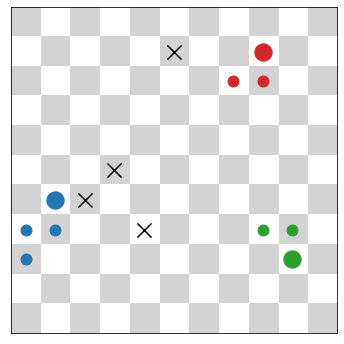

In [41]:
plt.figure(figsize=(6,6))
vis_board_state(board_state = my_engine.history[5])


#### Ego-centric view
Get the game state from the point of view of a specified snake

In [54]:
# 
def ego_centric(snake_index: int,
                board_state: np.ndarray,
                body_clip_max: bool = True) -> np.ndarray:
    ''' a stand-alone version that takes in a board state and snake index and returns an ego-centric representation '''
    
    if board_state[snake_index*3+2,0,0]==0: return 'snake is not alive'
    
    width, height = board_state.shape[1], board_state.shape[2]

    # -- define and fill buffered board
    buffered_board = np.zeros((board_state.shape[0]+1, width*2-1, height*2-1))
        
    # -- get head offset from board state
    _head_loc = np.array(np.where(board_state[snake_index*3]>0)).flatten()
    x_off = width - _head_loc[0] - 1  # x dist to center
    y_off = height - _head_loc[1] - 1 # y dist to center
    buffered_board[:-1,
                   x_off : x_off + width,
                   y_off : y_off + height] = board_state

    # add a layer to identify valid board locations
    buffered_board[-1,
                   x_off : x_off + width,
                   y_off : y_off + height] = 1

    # clips off body segment order by default
    if body_clip_max:
        for i in range(4):
            buffered_board[i*3+1] = np.clip(buffered_board[i*3+1],a_min=0,a_max=1)

    # shift snake to first position
    # (it's late, and this isn't worth optimizing)
    if snake_index == 1: buffered_board = buffered_board[[3,4,5,0,1,2,6,7,8,9,10,11,12,13]]
    if snake_index == 2: buffered_board = buffered_board[[6,7,8,3,4,5,0,1,2,9,10,11,12,13]]
    if snake_index == 3: buffered_board = buffered_board[[9,10,11,3,4,5,6,7,8,0,1,2,12,13]]

    # get neck location
    temp_board_state = board_state[snake_index*3 + 1]
    neck_location = np.array([temp_board_state.argmax()//width,
                              temp_board_state.argmax()%width]) # order may be wrong, but if it's a square, it doesn't matter

    # diff
    facing_angle = tuple(_head_loc - neck_location) 
    #print(facing_angle)
    
    # -- rotate board
    _facing_angle = facing_dict[facing_angle] # key of dictionary, returns 'N','S','W',or 'E'
    if _facing_angle == 'N': return buffered_board
    if _facing_angle == 'S': return np.rot90(buffered_board, k=2, axes=(1,2))
    if _facing_angle == 'W': return np.rot90(buffered_board, k=3, axes=(1,2))
    if _facing_angle == 'E': return np.rot90(buffered_board, k=1, axes=(1,2))


/var/folders/tn/9tq725tx3bj46cw90w451p_r0000gp/T/ipykernel_50824/2496410105.py:31: RuntimeWarning: divide by zero encountered in log
  if board_state.shape[0] == 14: plt.imshow(np.log(abs(board_state[13]-1)).T, alpha=0.4,origin='lower')


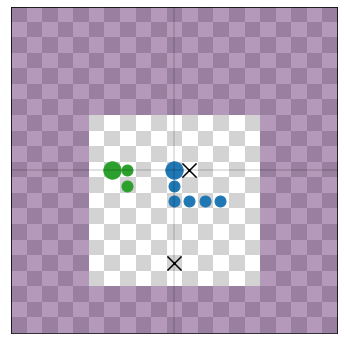

In [55]:
plt.figure(figsize=(6,6))
vis_board_state(ego_centric(snake_index=0,board_state = my_engine.history[12])) # game state from point of view of snake 0 at turn 12

plt.axvline(10,c='k',alpha=0.15)
plt.axhline(10,c='k',alpha=0.15)